<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v8: Productionising Activity capturing and visualisation
This notebook carries on from v5 with work to productionise the capture and display of unit activation information.

It uses a simple callback, and starts simple with its data collection.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout 65edb0b
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_vis_toolkit as tv
from importlib import reload
reload(tv)

Cloning into 'repo'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 256 (delta 52), reused 45 (delta 19), pack-reused 166 (from 1)
Receiving objects: 100% (256/256), 17.75 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Already up to date.


<module 'train_vis_toolkit' from '/content/repo/train_vis_toolkit.py'>

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


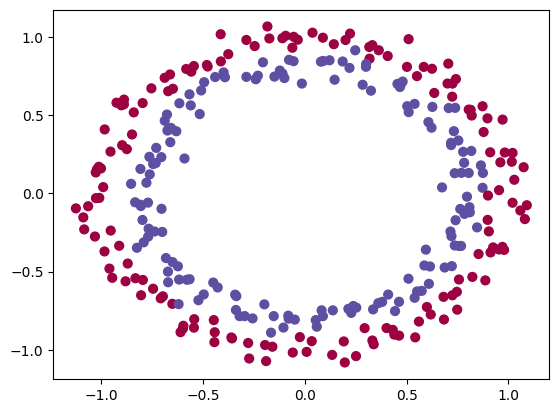

In [3]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [84]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)                    │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_253 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_255 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_257 (Dense)                    │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_258 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,211 (160.98 KB)

 Trainable params: 41,211 (160.98 KB)

 Non-trainable params: 0 (0.00 B)

## Baseline training function
To check that we don't break things below, let's get a "good" example as reference.

Epoch   100 - 70.12ms/epoch: loss: 0.0176  
Epoch   200 - 43.88ms/epoch: loss: 0.0584  
Epoch   300 - 38.41ms/epoch: loss: 0.0162  
Epoch   400 - 35.37ms/epoch: loss: 0.0116  
Epoch   500 - 51.10ms/epoch: loss: 0.0705  
Epoch   600 - 47.19ms/epoch: loss: 0.0003  
Epoch   700 - 45.61ms/epoch: loss: 0.0001  
Epoch   800 - 50.15ms/epoch: loss: 0.0000  
Epoch   900 - 57.33ms/epoch: loss: 0.0000  
Epoch  1000 - 67.38ms/epoch: loss: 0.0000  
Total training time: 50.87 secs


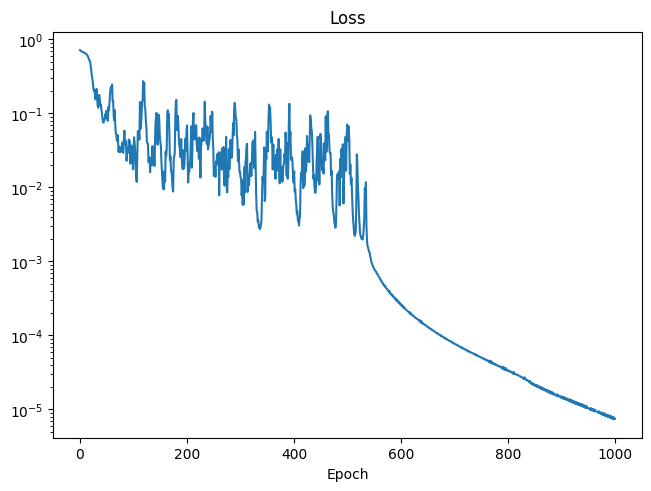

In [ ]:
# Using standard TF model.fit() function
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = model.fit(dataset.batch(32), epochs=1000, verbose=0, callbacks=[tv.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

## Modified training function
Now we'll use a modified training function that exposes individual layer activations by internally exposing all layers as model outputs.

In [40]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
basic_gradient_callback = tv.BaseGradientCallback()
history = tv.fit(model, dataset.batch(32), epochs=5, verbose=0, callbacks=[tv.LessVerboseProgressLogger(), basic_gradient_callback])

Epoch     1 - 5.11s/epoch: loss: 0.6931  
Epoch     2 - 66.53ms/epoch: loss: 0.6931  
Epoch     3 - 66.57ms/epoch: loss: 0.6931  
Epoch     4 - 74.26ms/epoch: loss: 0.6931  
Epoch     5 - 48.66ms/epoch: loss: 0.6931  


Epoch   100 - 73.21ms/epoch: loss: 0.0514  
Epoch   200 - 35.98ms/epoch: loss: 0.0045  
Epoch   300 - 49.77ms/epoch: loss: 0.0063  
Epoch   400 - 35.70ms/epoch: loss: 0.0014  
Epoch   500 - 37.83ms/epoch: loss: 0.0005  
Epoch   600 - 48.17ms/epoch: loss: 0.0002  
Epoch   700 - 41.54ms/epoch: loss: 0.0001  
Epoch   800 - 36.44ms/epoch: loss: 0.0000  
Epoch   900 - 47.90ms/epoch: loss: 0.0000  
Epoch  1000 - 44.98ms/epoch: loss: 0.0000  
Total training time: 45.28 secs


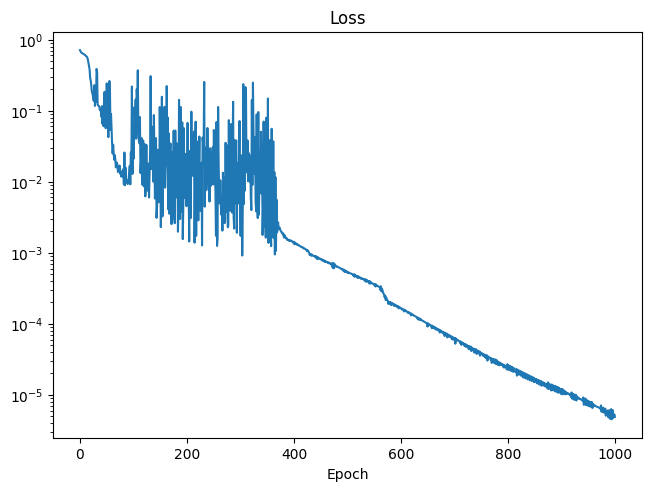

In [41]:
# Confirm it behaves as per normal in terms of actual training
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tv.fit(model, dataset.batch(32), epochs=1000, verbose=0, callbacks=[tv.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

Epoch     1 - 3.42s/epoch: loss: 0.7073  
Epoch     2 - 311.01ms/epoch: loss: 0.6802  
Epoch     3 - 311.37ms/epoch: loss: 0.6622  
Total training time: 4.14 secs


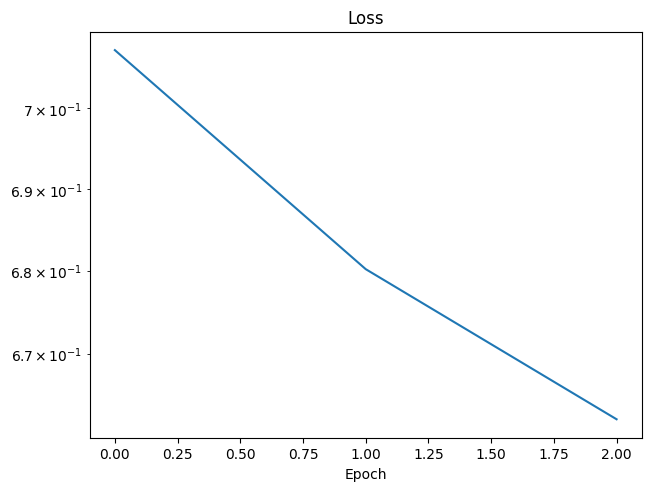

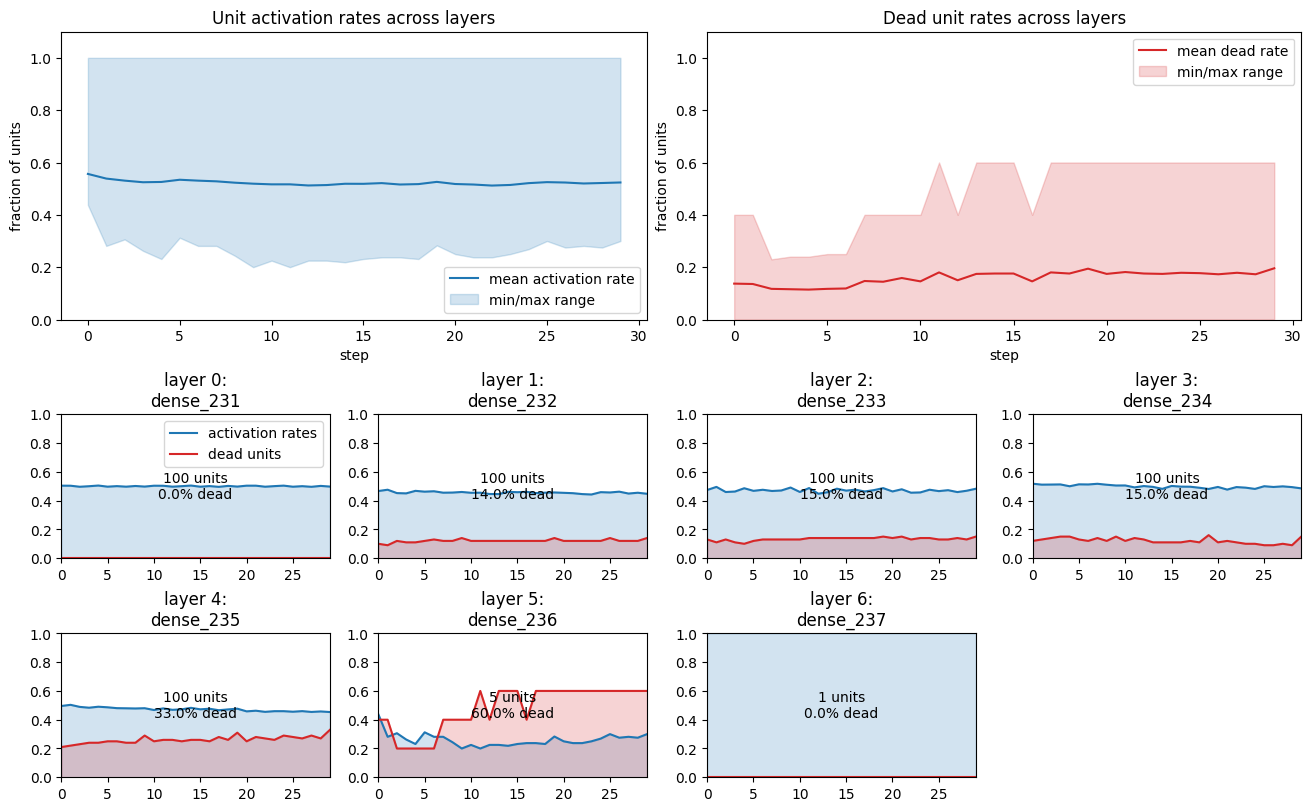

In [63]:
# Now let's collect activation data, including collecting raw activitions for a couple of selected layers
reload(tv)
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
activity = tv.ActivityHistoryCallback(per_step=True, collection_sets=[{'layer_indices': [1, 2]}])
history = tv.fit(model, dataset.batch(32), epochs=3, verbose=0, callbacks=[tv.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

plot_fit(history)
tv.plot_unit_activity(activity)

All activations collected: [None, '30 x (32, 100)', '30 x (32, 100)', None, None, None, None]


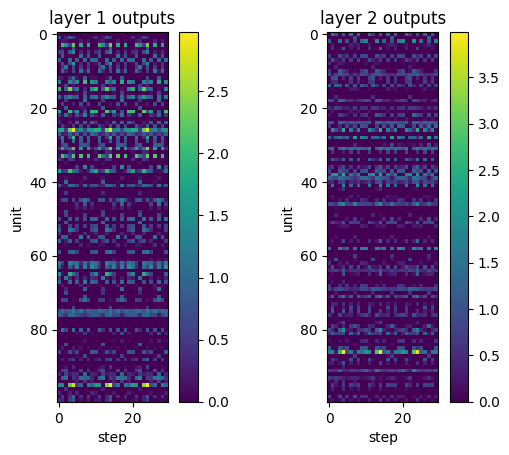

In [81]:
# And let's take a look at the recorded activations
activation_shapes = [f"{len(layer_outputs)} x {layer_outputs[0].shape}" if layer_outputs is not None else None for layer_outputs in activity.layer_outputs]
print(f"All activations collected: {activation_shapes}")

# plot heapmap of raw activation values for first input of each step, for both of the collected layers
plt.subplot(1,2,1)
plt.title('layer 1 outputs')
data = [iteration_output[0,:].numpy() for iteration_output in activity.layer_outputs[1]]
data = np.array(data).transpose()
plt.imshow(data)
plt.xlabel("step")
plt.ylabel("unit")
plt.colorbar()

plt.subplot(1,2,2)
plt.title('layer 2 outputs')
data = [iteration_output[0,:].numpy() for iteration_output in activity.layer_outputs[2]]
data = np.array(data).transpose()
plt.imshow(data)
plt.xlabel("step")
plt.ylabel("unit")
plt.colorbar()

plt.show()

Epoch   100 - 168.08ms/epoch: loss: 0.0084  
Epoch   200 - 138.18ms/epoch: loss: 0.0313  
Epoch   300 - 148.42ms/epoch: loss: 0.0062  
Epoch   400 - 139.76ms/epoch: loss: 0.0130  
Epoch   500 - 138.70ms/epoch: loss: 0.0128  
Epoch   600 - 137.95ms/epoch: loss: 0.0034  
Epoch   700 - 138.32ms/epoch: loss: 0.0002  
Epoch   800 - 137.46ms/epoch: loss: 0.0001  
Epoch   900 - 156.16ms/epoch: loss: 0.2123  
Epoch  1000 - 139.00ms/epoch: loss: 0.0032  
Total training time: 144.32 secs


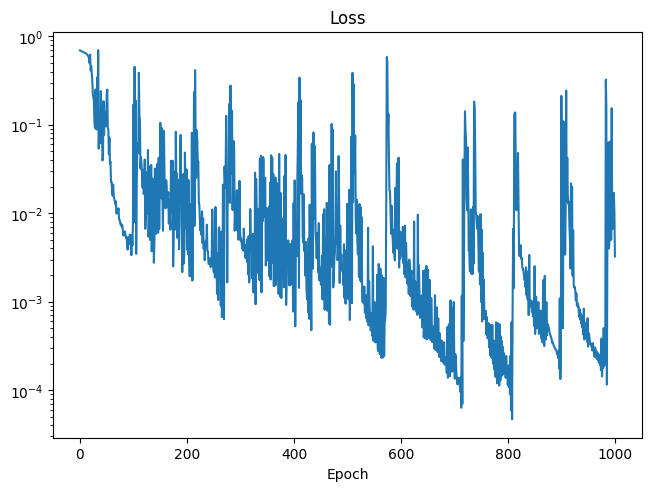

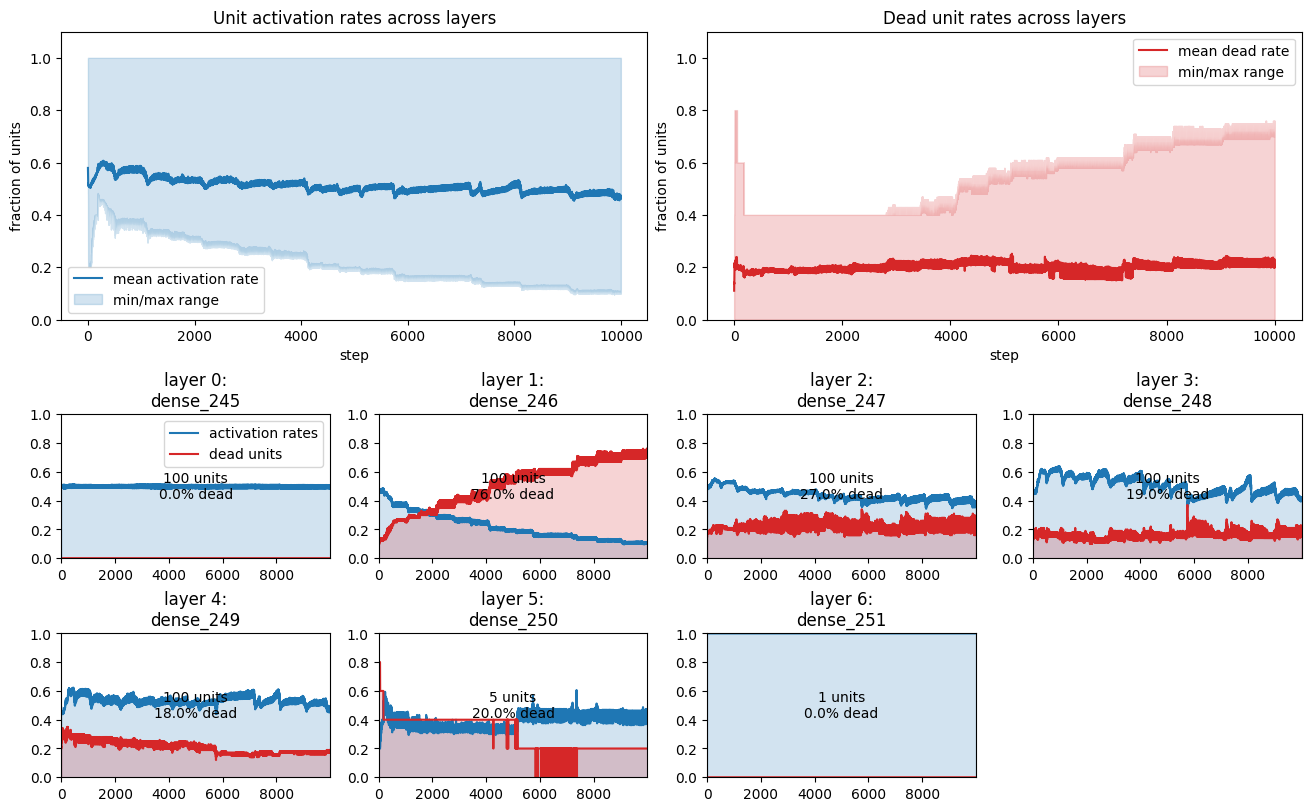

In [83]:
# Let's try collecting activation rates during a longer run
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
activity = tv.ActivityHistoryCallback(per_step=True)
history = tv.fit(model, dataset.batch(32), epochs=1000, verbose=0, callbacks=[tv.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

tv.plot_unit_activity(activity)

## MNIST Model
Now let's try against the MNIST database and model.

In [85]:
def mnist_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


In [ ]:
mnist_model().summary()

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8358 - loss: 0.3049
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9608 - loss: 0.1238
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9738 - loss: 0.0832
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9809 - loss: 0.0613
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9845 - loss: 0.0478
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9869 - loss: 0.0371
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9879 - loss: 0.0336
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9902 - loss: 0.0278
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9919 - loss: 0.0255
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9925 - loss: 0.0244
Total training time: 166.11 secs


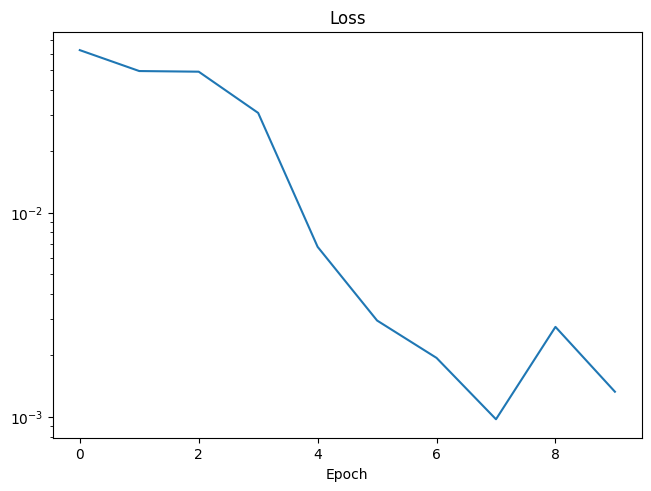

AttributeError: 'ActivityHistoryCallback' object has no attribute 'plot_summary'

In [87]:
start = tf.timestamp()
model = mnist_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = tv.ActivityHistoryCallback(per_step=True)
history = tv.fit(model, dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

activity.plot_summary()

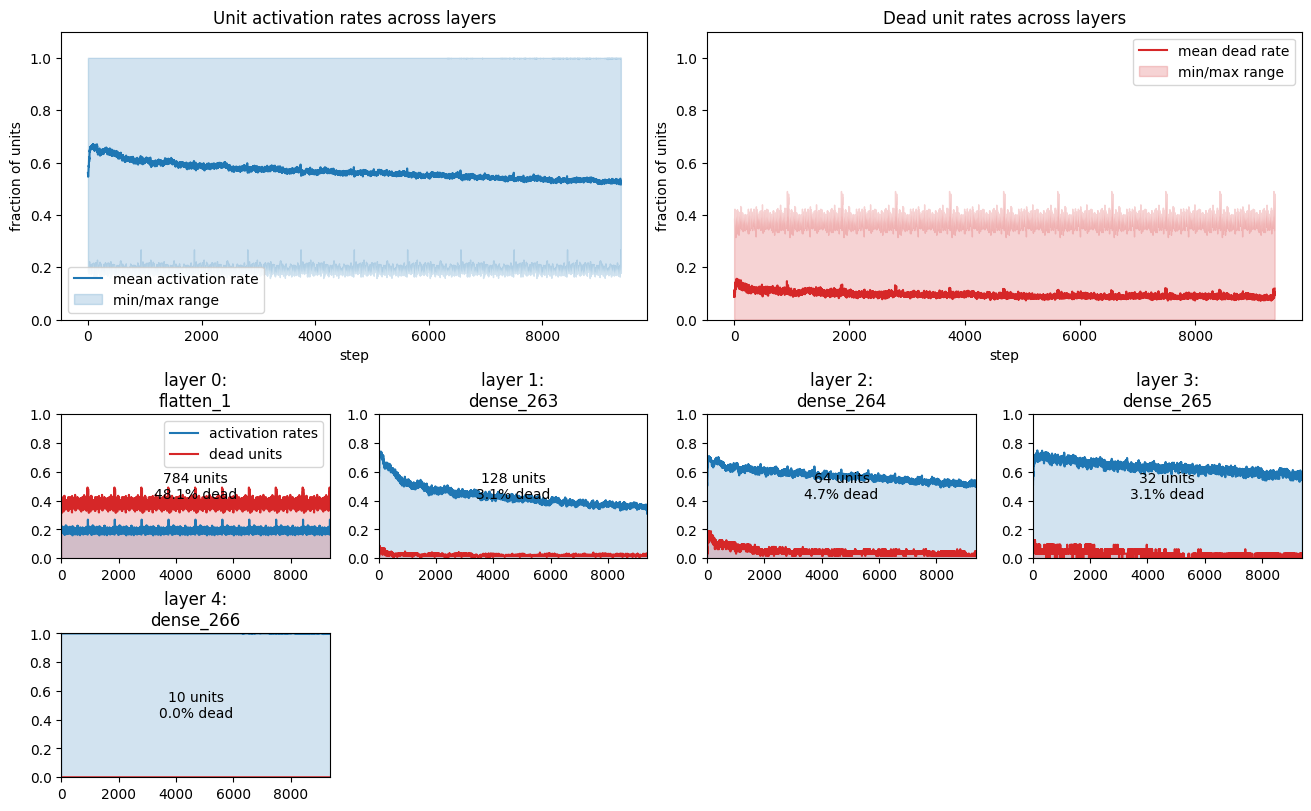

In [88]:
tv.plot_unit_activity(activity)

## MNIST CNN Model
The basic MNIST model above isn't much more interesting than the 2D-linear regression problem as it only uses Dense layers.
Let's up the ante with a CNN model.


In [4]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


In [90]:
mnist_cnn_model().summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 938/938 [00:20<00:00, 44.76it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.0, 'mean_dead_rate': 0.0, 'min_activation_rate': 0.16170578, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.42920718}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.0, 'activation_rate': 0.16170578}, {'dead_rate': 0.0, 'activation_rate': 0.26114827}, {'dead_rate': 0.0, 'activation_rate': 0.444242}, {'dead_rate': 0.0, 'activation_rate': 0.44424197}, {'dead_rate': 0.0, 'activation_rate': 0.5019151}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([]), TensorShape([]), TensorShape([])]


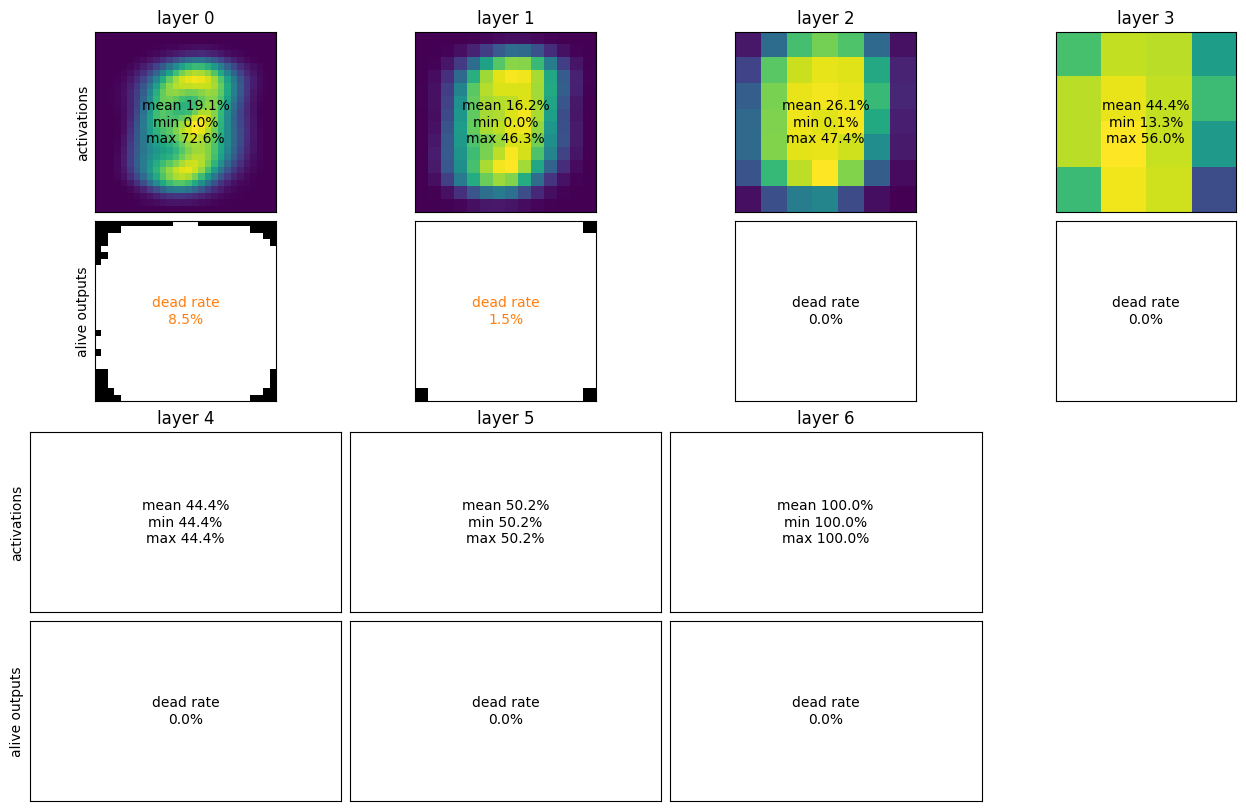

In [91]:
# Before any training
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
model_stats, layer_stats, layer_spatial_stats = tv.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

tv.plot_spatial_stats(layer_spatial_stats)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 54s 55ms/step - accuracy: 0.8554 - loss: 0.2183
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.9768 - loss: 0.0693
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.9858 - loss: 0.0446
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.9895 - loss: 0.0305
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.9929 - loss: 0.0235
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - accuracy: 0.9935 - loss: 0.0194
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.9957 - loss: 0.0145
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.9958 - loss: 0.0127
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.9965 - loss: 0.0108
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.9956 - loss: 0.0102
Total training time: 533.72 secs


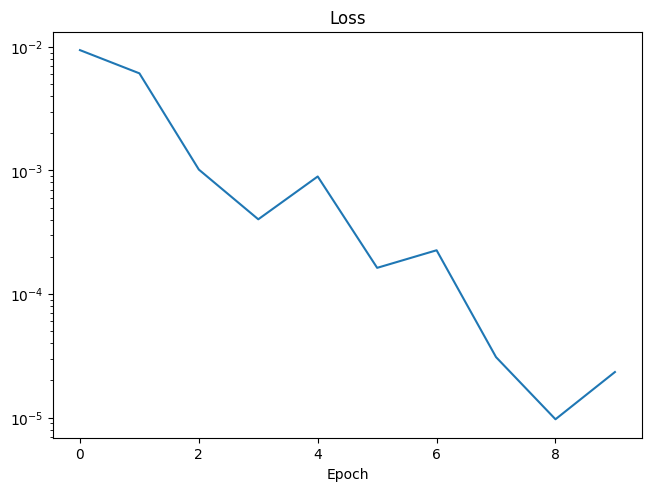

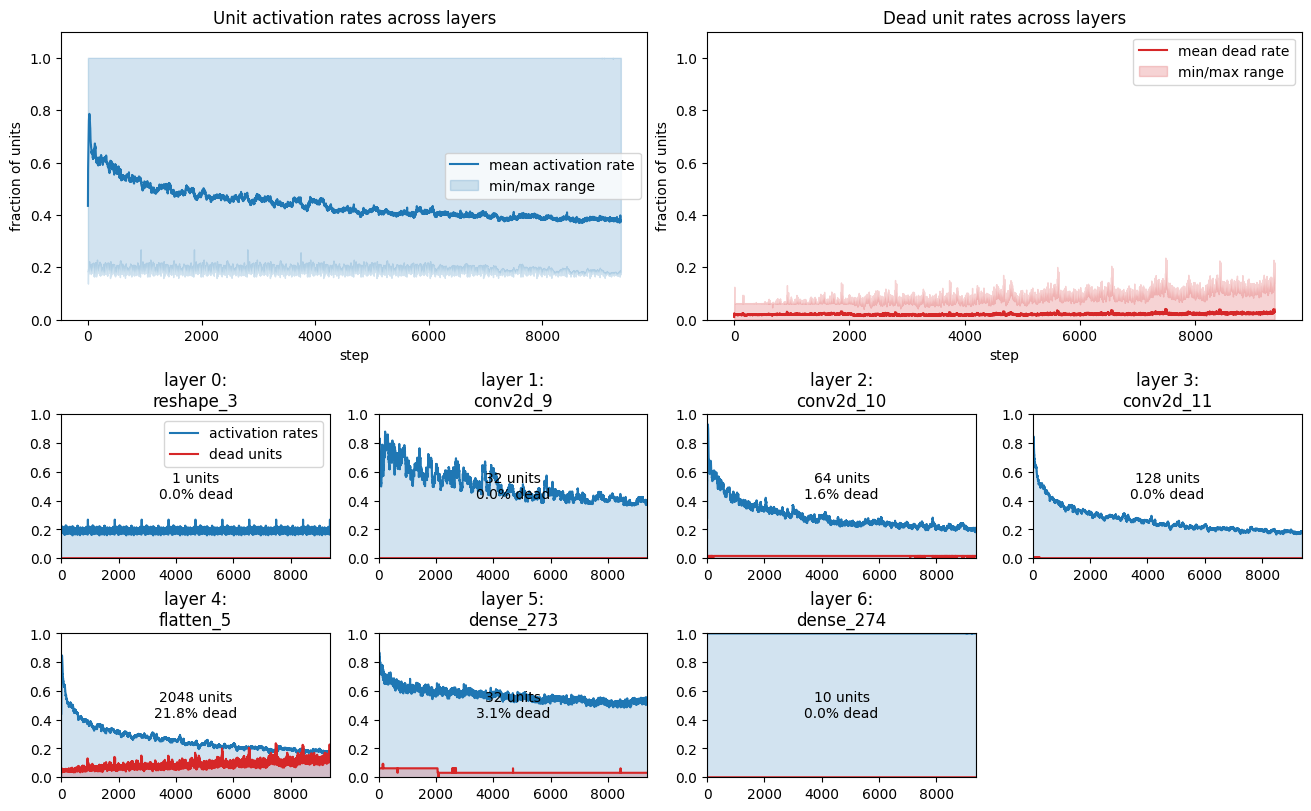

In [93]:
# Model training - collecting activity per step
start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = tv.ActivityHistoryCallback(per_step=True)
history = tv.fit(model, dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

tv.plot_unit_activity(activity)

Note that unit activation and dead rates are calculated per-sample. For per-step collection, this biases towards a pessimistic interpretation because some units will only be active for certain inputs. So for understanding actual dead rates, it can be better to measure across epochs.

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8553 - loss: 0.2283
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9770 - loss: 0.0691
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9850 - loss: 0.0443
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9900 - loss: 0.0303
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9925 - loss: 0.0231
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9944 - loss: 0.0179
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9942 - loss: 0.0158
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9956 - loss: 0.0123
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9960 - loss: 0.0109
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9966 - loss: 0.0107
Total training time: 94.49 secs


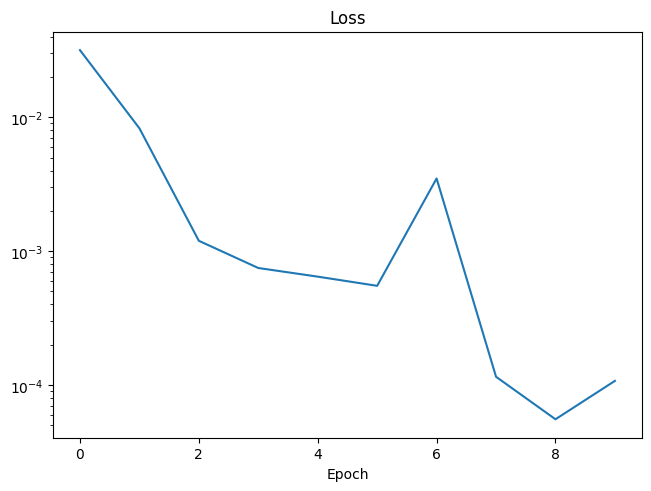

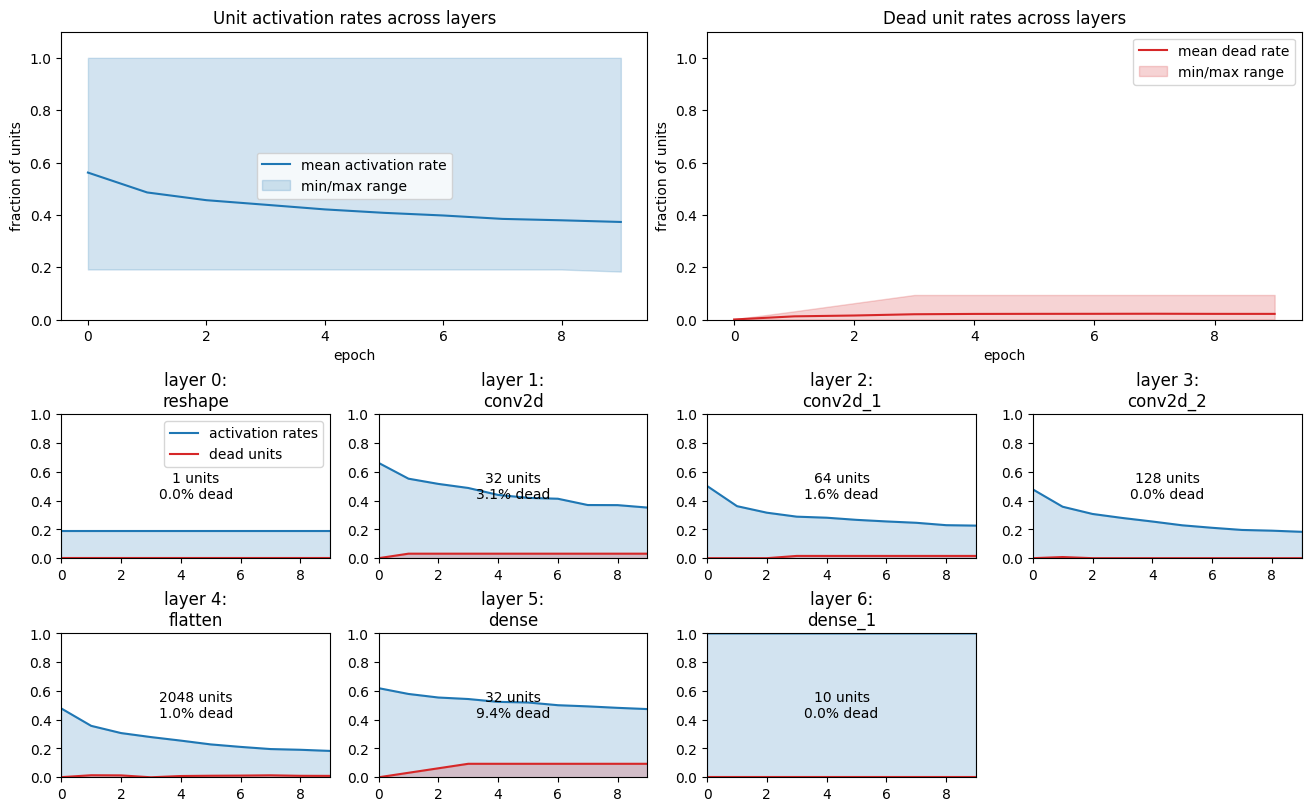

In [5]:
# Model training - collecting activity per epoch
start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = tv.ActivityHistoryCallback(per_step=False)
history = tv.fit(model, dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

tv.plot_unit_activity(activity)

100%|██████████| 938/938 [00:03<00:00, 278.59it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.09375, 'mean_dead_rate': 0.021763392857142856, 'min_activation_rate': 0.17844847, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.3673665}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.03125, 'activation_rate': 0.33493954}, {'dead_rate': 0.015625, 'activation_rate': 0.21209063}, {'dead_rate': 0.0, 'activation_rate': 0.17844847}, {'dead_rate': 0.01171875, 'activation_rate': 0.17844847}, {'dead_rate': 0.09375, 'activation_rate': 0.4764412}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([]), TensorShape([]), TensorShape([])]


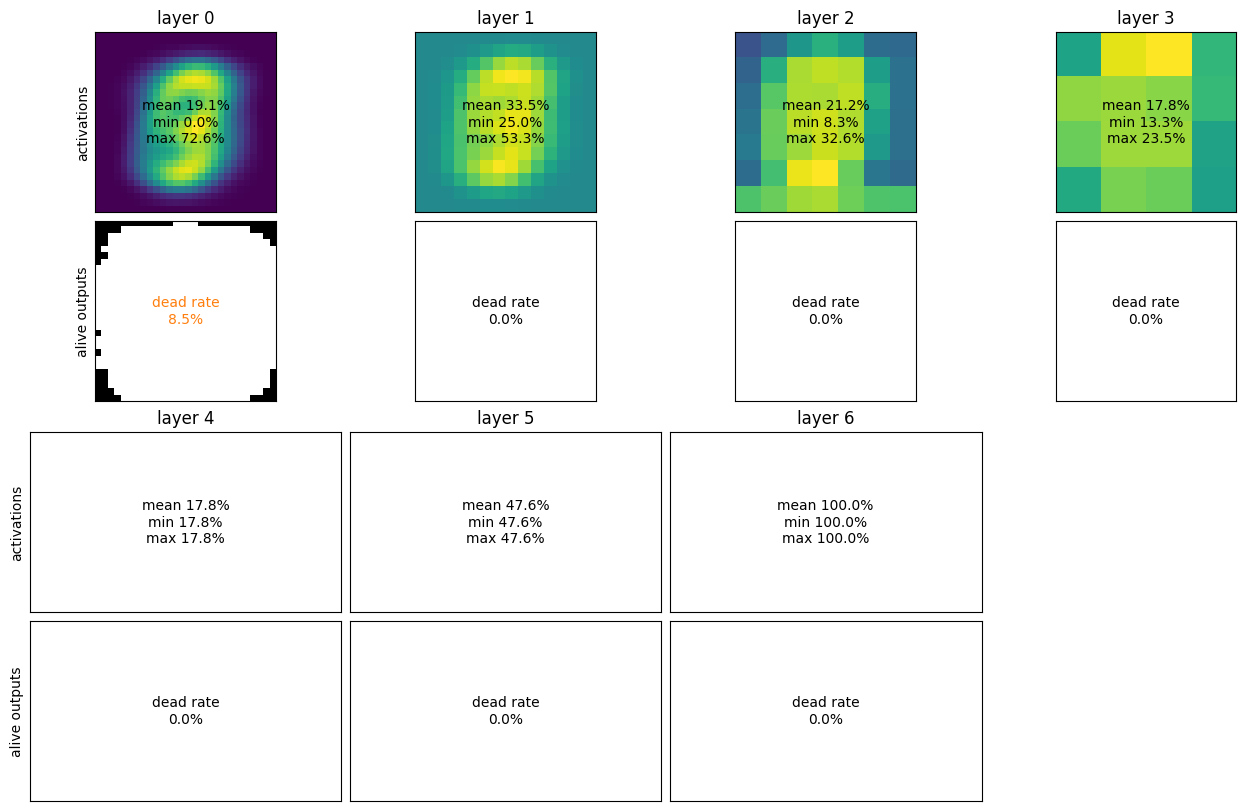

In [6]:
# and show spatial stats at end
model_stats, layer_stats, layer_spatial_stats = tv.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

tv.plot_spatial_stats(layer_spatial_stats)

100%|██████████| 938/938 [00:02<00:00, 332.35it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.09375, 'mean_dead_rate': 0.021763392857142856, 'min_activation_rate': 0.17844847, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.3673665}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.03125, 'activation_rate': 0.33493954}, {'dead_rate': 0.015625, 'activation_rate': 0.21209063}, {'dead_rate': 0.0, 'activation_rate': 0.17844847}, {'dead_rate': 0.01171875, 'activation_rate': 0.17844847}, {'dead_rate': 0.09375, 'activation_rate': 0.4764412}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_channel_stats: x[TensorShape([1]), TensorShape([32]), TensorShape([64]), TensorShape([128]), TensorShape([2048]), TensorShape([32]), TensorShape([10])]


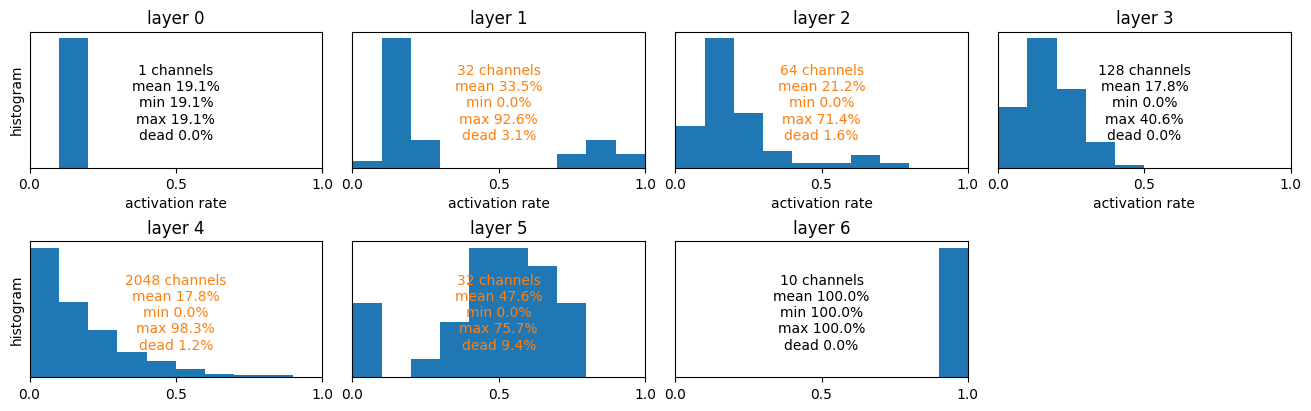

In [7]:
# channel stats at end
# Note that dead rates here are very close to those measured during training with per-epoch sampling
model_stats, layer_stats, layer_channel_stats = tv.measure_unit_activity(model, dataset, include_channel_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_channel_stats: x{[stat.shape for stat in layer_channel_stats]}")

tv.plot_channel_stats(layer_channel_stats)